# **`Hotel Bookings Cancelation Predictions`**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# PreProcessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from category_encoders import BinaryEncoder
import category_encoders as ce
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Splitting Data
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
import lightgbm
from sklearn.metrics import classification_report, confusion_matrix

# Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

> ## Notebook Content

- Problem Statement
- Data Understanding
- Exploratory Data Analysis
- Preprocessing
- Methodology (Modeling/Analysis)
- Conclusion and Recommendation

> ## Problem Statement


The hotel booking dataset is used to understand what customer characteristics that is likely to cancel. Furthermore, these features is used for machine learning training in predicting cancelation so hotel owners can mitigate costumers that is likely to cancel. It would be very helpful for the hotel management to have a model that can predict if a guests will cancel and also know what factors made a guest cancels, so they can manage it easier especially in high peak seasons.

`0` Not Canceled, `1` Canceled

We will use classification model to help hotel companies to predict the probability a customer would cancel. The model will then be measured with a certain metric. The metric is basically a probability of four possible outcomes which is defined below:

- True Positive (TP): predicted is the same as actual, which means model predicts people that cancels their booking.

- False Positive (FP): predicted as canceled but actually the customer came to the hotel.

- False Negative (FN): predicted as not canceled but actually the customer canceled the booking.

- True Negative (TN): predicted as not canceled and the customer camed and stayed at the hotel.

The false predicition in this model will have two consequences, the first one is the customer that is predicted to cancel actually came, which will be a disaster due to complaints because the room reserved is already canceled. The other one is when predicted not canceled but the guest actually canceled or did not turn up, which is not very much of a problem because the room can always be reselled for upcoming guests.

As defined, the metric that we will use on predicting the cancelation is using precision score to specify our focus on the prediction of cancelation that is 1 (Canceled) and pay more attention towards true positive and false positive.


> ## Data Understanding


Source : [Hotel Booking Demand Dataset](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand)

- The data contains hotel bookings due to arrive between 2015 and 2017
- Each record of data represents information related to ordering transactions that occur
- Unbalance dataset (is_canceled)

`Attribute Information`

`hotel` (H1 = Resort Hotel or H2 = City Hotel)

`is_canceled` Value indicating if the booking was canceled (1) or not (0)

`lead_time` Number of days that elapsed between the entering date of the booking into the PMS and the arrival date

`arrival_date_year` Year of arrival date

`arrival_date_month` Month of arrival date

`arrival_date_week_number` Week number of year for arrival date

`arrival_date_day_of_month` Day of arrival date

`stays_in_weekend_nights` Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel

`stays_in_week_nights` Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel

`adults` Number of adults

`children` Number of children

`babies` Number of babies

`meal` Type of meal booked. Categories are presented in standard hospitality meal package Undefined/SC – no meal

`country` Country of origin. Categories are represented in the ISO 3155–2013 format

`market_segment` Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”

`distribution_channel` Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”

`is_repeated_guest` Value indicating if the booking name was from a repeated guest (1) or not (0)

`previous_cancellations` Number of previous bookings that were cancelled by the customer prior to the current booking

`previous_bookings_not_canceled` Number of previous bookings not cancelled by the customer prior to the current booking

`reserved_room_type` Code of room type reserved. Code is presented instead of designation for anonymity reasons

`assigned_room_typeCode` for the type of room assigned to the booking.Code is presented instead of designation for anonymity reasons

`booking_changes` Number of changes made to the booking from the moment the booking was entered on the PMS until the moment of check-in or out

`deposit_type` Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categorie No

`agent` ID of the travel agency that made the booking

`company` ID of the company that made the booking or responsible for paying the booking

`days_in_waiting_list` Number of days the booking was in the waiting list before it was confirmed to the customer

`customer_type` Type of booking, assuming one of four categorieTransient - Transient-Party - Contract - Group

`adr` Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights

`required_car_parking_spaces` Number of car parking spaces required by the customer

`total_of_special_requests` Number of special requests made by the customer (e.g. twin bed or high floor)

`reservation_status Reservation` last status, assuming one of three categorie Canceled – booking was canceled by the customer; Check-Out

`reservation_status_date` Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to 

In [2]:
# load dataset
df = pd.read_csv('hotel_bookings.csv')

In [3]:
# show head
pd.set_option("display.max_rows", None)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# check info
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,hotel,object,0,0.00,2,"[Resort Hotel, City Hotel]"
1,is_canceled,int64,0,0.00,2,"[0, 1]"
2,lead_time,int64,0,0.00,479,"[173, 299]"
3,arrival_date_year,int64,0,0.00,3,"[2017, 2015]"
4,arrival_date_month,object,0,0.00,12,"[April, August]"
5,arrival_date_week_number,int64,0,0.00,53,"[7, 27]"
6,arrival_date_day_of_month,int64,0,0.00,31,"[1, 30]"
7,stays_in_weekend_nights,int64,0,0.00,17,"[13, 4]"
8,stays_in_week_nights,int64,0,0.00,35,"[19, 25]"
9,adults,int64,0,0.00,14,"[6, 5]"


The 'company' feature is considered to be dropped as it has 94% NaN values, and will be handle in preprocessing section

We should reformat reservation status date to date and time format, also the arrival date into a new date and time feature.

In [5]:
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Creating the arrival date full feature: 
df['arrival_date_full'] = df['arrival_date_year'].astype(str) + "-" + df['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + df['arrival_date_day_of_month'].astype(str)
df['arrival_date_full'] = pd.to_datetime(df['arrival_date_full'], format="%Y-%m-%d")

The day difference between arrival date and reservation status date can be calculated now with the format both as date and time. For not canceling customers this difference represent how long they stayed, while for canceling customers this number represent their cancelation days prior arrival date that was booked. Below is the difference calculation and reformating to integer type.

In [6]:
# Creating a new feature representing length of stay or how many days before arrival did the customer cancel:
df['status_minus_arrival_date'] = np.abs(df['arrival_date_full'] - df['reservation_status_date']).astype(str)
# formating the feature 
def format_lenght(date):
    return date[0]
df['status_minus_arrival_date'] = df['status_minus_arrival_date'].map(format_lenght).astype(int)

Checking all features unique values to check if there any values that are still not quite right such as 'Undefined'.

In [7]:
for col in df.columns:
    print(f"{col}: \n{df[col].unique()}\n")

hotel: 
['Resort Hotel' 'City Hotel']

is_canceled: 
[0 1]

lead_time: 
[342 737   7  13  14   0   9  85  75  23  35  68  18  37  12  72 127  78
  48  60  77  99 118  95  96  69  45  40  15  36  43  70  16 107  47 113
  90  50  93  76   3   1  10   5  17  51  71  63  62 101   2  81 368 364
 324  79  21 109 102   4  98  92  26  73 115  86  52  29  30  33  32   8
 100  44  80  97  64  39  34  27  82  94 110 111  84  66 104  28 258 112
  65  67  55  88  54 292  83 105 280 394  24 103 366 249  22  91  11 108
 106  31  87  41 304 117  59  53  58 116  42 321  38  56  49 317   6  57
  19  25 315 123  46  89  61 312 299 130  74 298 119  20 286 136 129 124
 327 131 460 140 114 139 122 137 126 120 128 135 150 143 151 132 125 157
 147 138 156 164 346 159 160 161 333 381 149 154 297 163 314 155 323 340
 356 142 328 144 336 248 302 175 344 382 146 170 166 338 167 310 148 165
 172 171 145 121 178 305 173 152 354 347 158 185 349 183 352 177 200 192
 361 207 174 330 134 350 334 283 153 197 133 241 193

Besides NaN data that we saw earlier, the data also has a couple of values that are filled with Undefined and values that does not make sense which is negative or outliers.

In [8]:
# describe numerical
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,status_minus_arrival_date
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,...,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,...,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363,3.077234
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,...,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798,2.135618
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000,1.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000,3.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000,4.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,9.000000


In [9]:
# describe categorical
df.describe(exclude='number')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,arrival_date_full
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,177,8,5,10,12,3,4,3,926,793
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-10-21 00:00:00,2015-12-05 00:00:00
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166,1461,448
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-10-17 00:00:00,2015-07-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-09-14 00:00:00,2017-08-31 00:00:00


> ## Exploratory Data Analysis

To understand the data better to help predict cancelation, we are going to focus the features towards cancelation and how does it behave.

> #### Cancelation

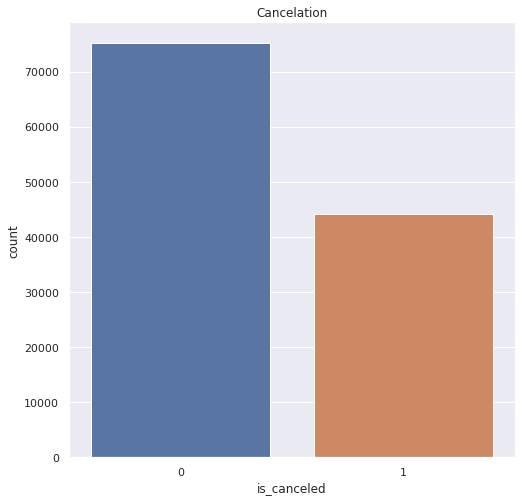

In [10]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(8,8))
sns.countplot(data=df, x='is_canceled')
plt.title('Cancelation')
plt.show()

First of all we check the data distribution of how much canceling and not cancel. We can see that the data total not cancel (0) is much more than cancel (1). This indicates data imbalance, we note this for now and get back to it further in the notebook.

In [11]:
df['is_canceled'].value_counts()/len(df['is_canceled'])*100

0    62.958372
1    37.041628
Name: is_canceled, dtype: float64

`0` Not Canceled, `1` Canceled

Not canceled more occurred than canceled which means it is good with percentage 63 : 37. With this proportion, imbalance handling must be carried out due to imbalance.

Features that will be used further are checked. Numericals are rank with correlation with the target feature, and caterogical are checked using simple data visualization and data analysis.

In [12]:
df.corr().abs()['is_canceled'].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
status_minus_arrival_date         0.010512
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

From the numerical features, the correlation with is_canceled is quite low from all of the features which means the data is quite complex. But nonetheless, it is still able to be used with tree based models that can handle complexity. Let's note these for now.

> #### Hotel

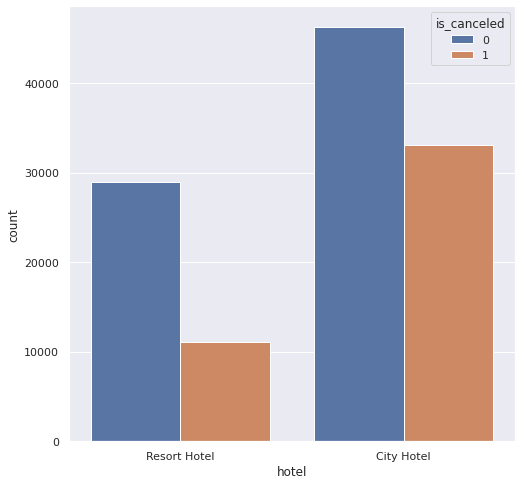

In [13]:
# type hotel plot
plt.figure(figsize=(8,8))
sns.countplot(data=df, x='hotel', hue='is_canceled')
plt.show()

`Hotel` Canceled mostly happened in city hotel rather than resort hotel giving insight people tend to cancel while it is at the city that has many option of places to stay.

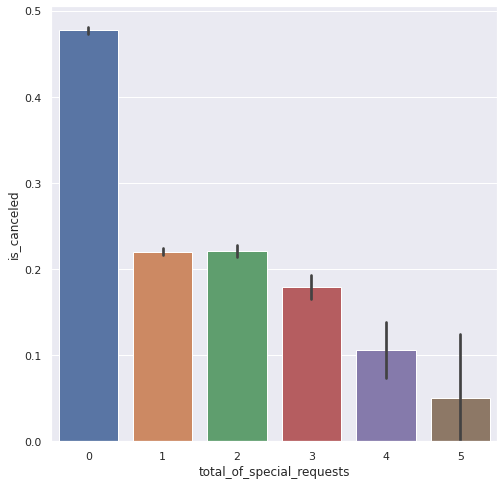

In [14]:
# total special request
plt.figure(figsize=(8,8))
sns.barplot(x=df['total_of_special_requests'], y=df['is_canceled'])
plt.show()

`Special Request` Less special requests is much more likely to cancel than high requests. This is because the customer that has special request is more likely to have a well planned trip rather than customers without special requests.

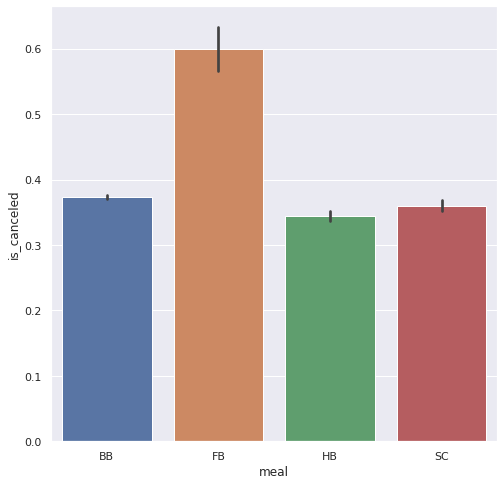

In [15]:
# meal, with feature engineering of undefined values classed as SC (no meal)
df.loc[df["meal"]=='Undefined', "meal"] = 'SC'

plt.figure(figsize=(8,8))
sns.barplot(x=df['meal'], y=df['is_canceled'])
plt.show()

`Meal` People with meal Full Breakfast tends to cancel than other types of meal order. Perhaps this is related to additional price which is more expensive than other type of meal.

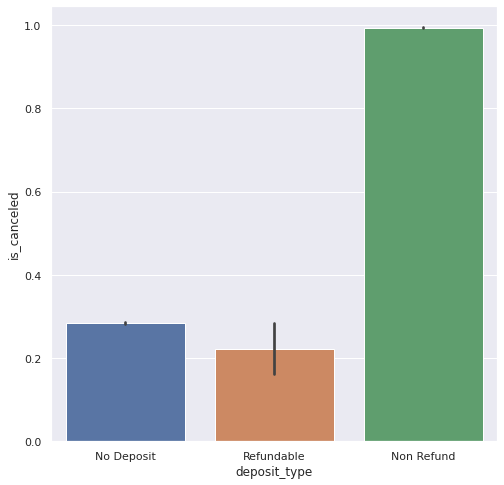

In [16]:
# deposit type
plt.figure(figsize=(8,8))
sns.barplot(x=df['deposit_type'], y=df['is_canceled'])
plt.show()

`Deposit Type` Non-Refund is likely to cancel all the time which is quite unusual. Usually non-refundable types of booking are the ones that are made very close to arrival date, impulsive bookings, but looking at the data the time customer made the booking and arrive to the hotel (lead_time) is quite long, perhaps there is another reason. Perhaps the terms from the hotel with non-refundable option made customers uncomfortable/confusing.

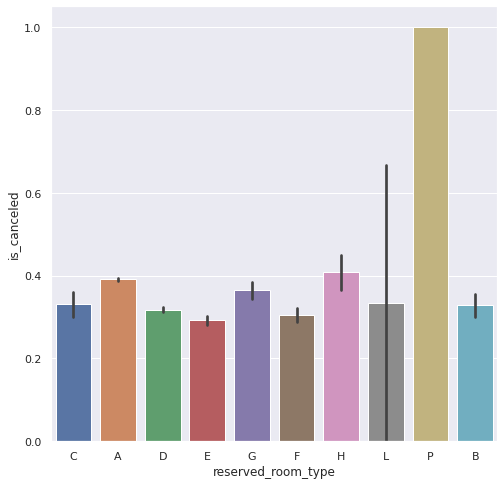

In [17]:
# reserved room type
plt.figure(figsize=(8,8))
sns.barplot(x=df['reserved_room_type'], y=df['is_canceled'])
plt.show()

`Room Type` Most cancelations was made when the booking was reserved room type P. This is not very clear of why cancelation took place on these types of room, perhaps additional detail on hotel description of the room would give an answer of why these types of room are always being canceled. Probably the room type has bad review or the specs is not what customer hoped for.

> #### Time

Before we have spotted the anomalies that are present in adr and lead time which we will handle those first

In [18]:
# define outlier function
def find_anomalies(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    limit = iqr*1.5
    print(f'IQR: {iqr}')

    bottom_limit = q1 - limit
    top_limit = q3 + limit
    print(f'bottom limit: {bottom_limit}')
    print(f'top limit: {top_limit}')

In [19]:
find_anomalies(df['adr'])

IQR: 56.709999999999994
bottom limit: -15.774999999999991
top limit: 211.065


In [20]:
find_anomalies(df['lead_time'])

IQR: 142.0
bottom limit: -195.0
top limit: 373.0


In [21]:
# negative values in lead time is changed to mean because adr won't be negative or zero, and limited with the top limit.
df.loc[df["adr"]<=0, "adr"] = 102
df.loc[df["adr"]>211, 'adr'] = 102
# outliers in adr is changed to mean, and it also won't be negative, and also limited with the top limit.
df.loc[df["lead_time"]<0, "lead_time"] = 104
df.loc[df["lead_time"]>373, 'lead_time'] = 104

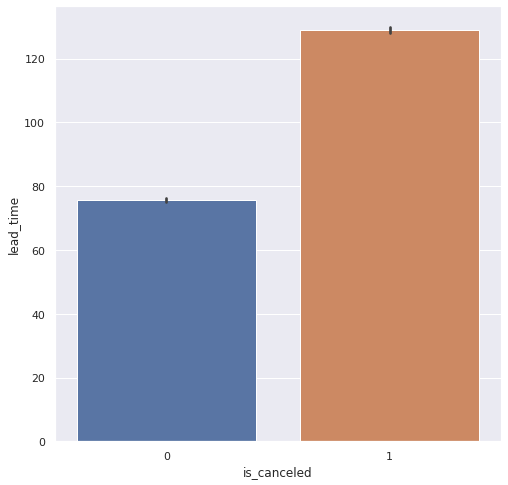

In [22]:
# lead time for cancelation
plt.figure(figsize=(8,8))
sns.barplot(x=df['is_canceled'], y=df['lead_time'])
plt.show()

`Lead Time` We can see very clear that when the booking was made very far in advance, people tend to cancel rather then keeping it because he costumer plans is more likely to change the longer it gets.

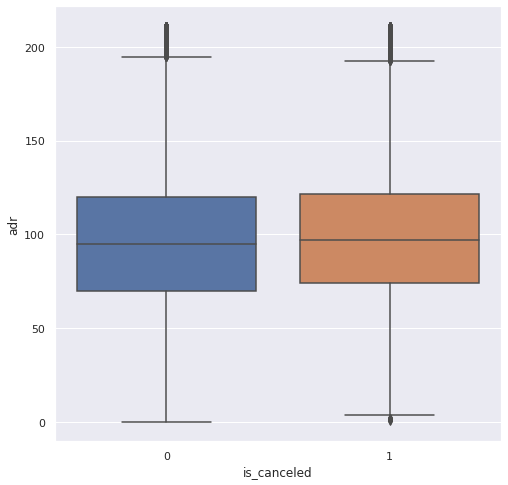

In [23]:
# average daily rate that is more likely to cancel
plt.figure(figsize=(8,8))
sns.boxplot(x='is_canceled', y='adr', data=df)
plt.show()

`ADR` From the average daily rate box plot, we can see that both canceled and not canceled has the same price range around 60-120 USD. But we can still see cancelation happens at slightly more expensive rates hotels.

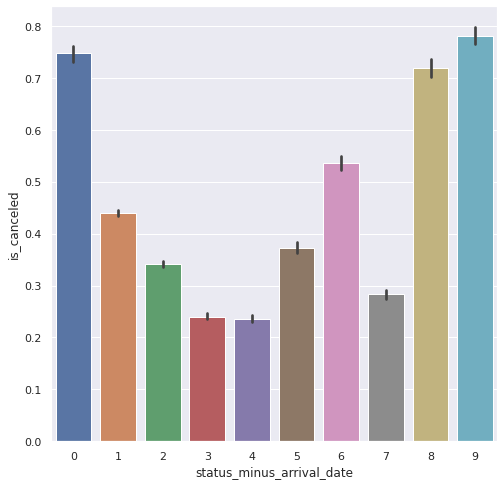

In [24]:
# status minus arrival date time for canceling
plt.figure(figsize=(8,8))
sns.barplot(x=df['status_minus_arrival_date'], y=df['is_canceled'])
plt.show()

`Status minus Arrival Date` From here, customers tend to cancel close to the arrival date (0 days) due to sudden events or far before (9 days prior) due to change of plans.

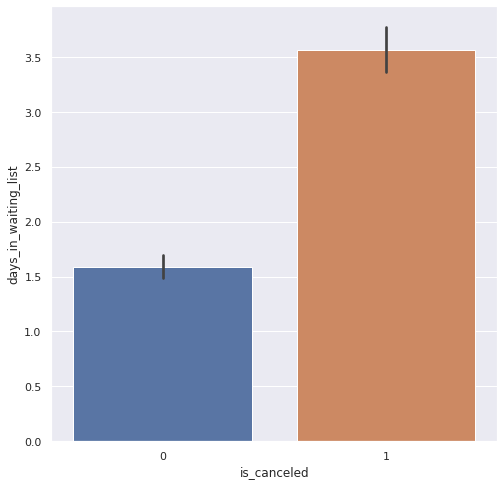

In [25]:
# days in waiting list
plt.figure(figsize=(8,8))
sns.barplot(x=df['is_canceled'], y=df['days_in_waiting_list'])
plt.show()

`Days in Waiting List` This makes sense as customers do not like to be in waiting list for their booking even just for three days, they tend to cancel with longer wait times because unsecure bookings is very risky for their trip.

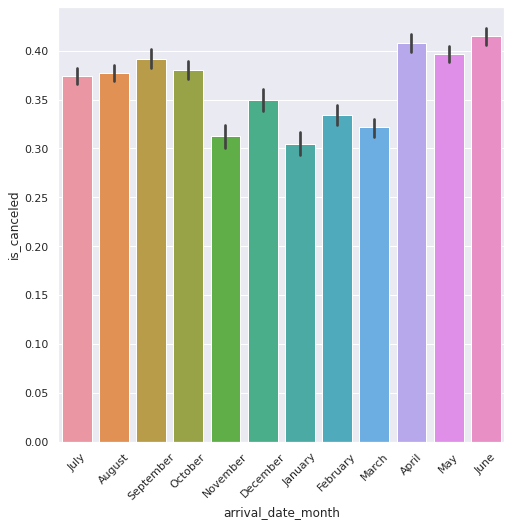

In [26]:
# month effect on cancelation
plt.figure(figsize=(8,8))
sns.barplot(x=df['arrival_date_month'], y=df['is_canceled'])
plt.xticks(rotation=45)
plt.show()

`Month Arrival Date` We can see in the graph in months that is holiday season is more likely to be canceled, this is probably due to the much more variety of customers that books the hotel such as families or groups of people that are on a holiday which can have change of plans, while in non vacation season bookings are probably made by employees for business trips that is a much more fixed booking.

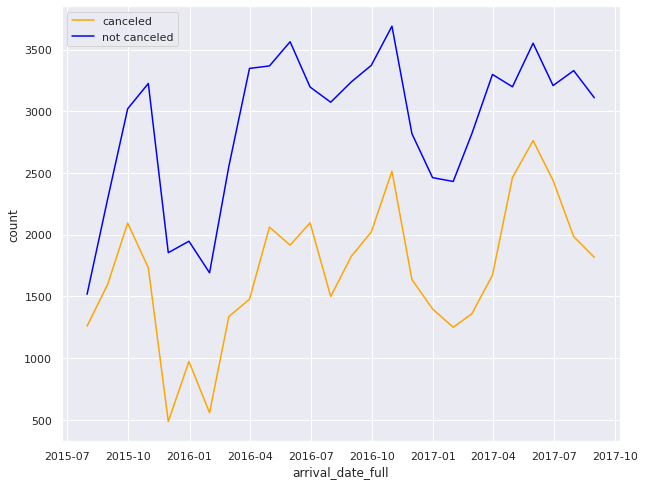

In [27]:
# created a dataframe of canceled bookings for plotting purposes
canceled = df[df['is_canceled']==1][['arrival_date_full']]
canceled.set_index('arrival_date_full', inplace=True)
canceled['count'] = 1
canceled=canceled.resample('M').sum()

# created a dataframe of not canceled bookings for plotting purposes
not_canceled = df[df['is_canceled']==0][['arrival_date_full']]
not_canceled.set_index('arrival_date_full', inplace=True)
not_canceled['count'] = 1
not_canceled=not_canceled.resample('M').sum()

# visualizing the number of canceled and not canceled bookings by date
plt.figure(figsize=(10,8))
sns.lineplot(x=canceled.index, y=canceled['count'], color='orange')
sns.lineplot(x=not_canceled.index, y=not_canceled['count'], color='blue')
plt.legend(['canceled', 'not canceled'])
plt.show()

`Arrival Date` From the complete set 2015-2017 data of booking arrival dates, it shows that bookings are much more made for seasonal months which are in the middle and at the end of the year. These peak seasons are the important times to predict cancelation especially in this busy moments when we don't want to miss predict giving customers a bad experience, keeping in mind cancelations are also likely to be made in these time of the year from the previous graph.

> #### Customer

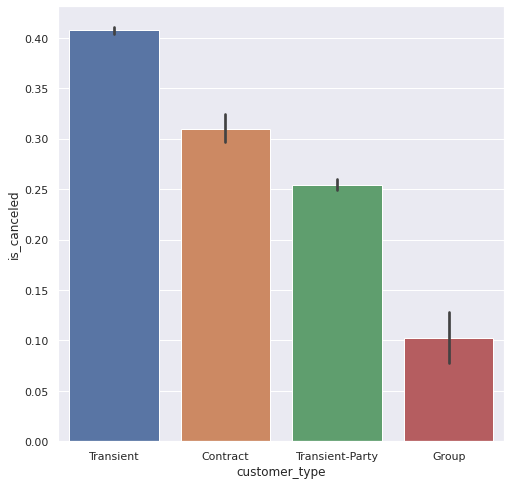

In [28]:
# customer type
plt.figure(figsize=(8,8))
sns.barplot(x=df['customer_type'], y=df['is_canceled'])
plt.show()

`Customer Type` Transient type customer (people that book only for short time) are the most likely to cancel, 10 percent higher than the second highest which is contract. Transient costumers might have other options for their short stay like staying at a friend, while transient group cannot easily do so. The group in this feature is different than the group in market segment. Here group is interpreted as booking lots of rooms like around 10 rooms for company meetings for example, meaning it is unlikely to be canceled.

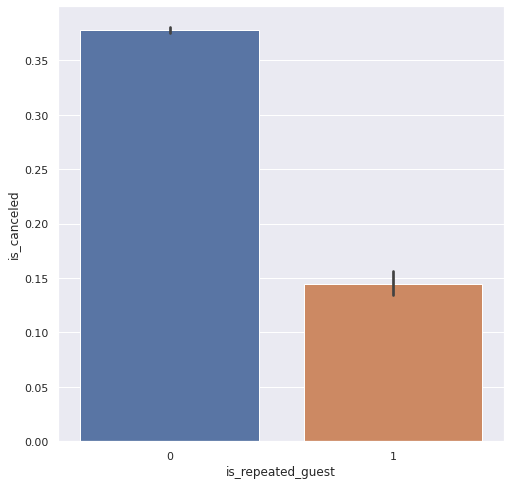

In [29]:
# repeated guest
plt.figure(figsize=(8,8))
sns.barplot(x=df['is_repeated_guest'], y=df['is_canceled'])
plt.show()

`Repeated Guest` Not repeated guests tends to cancel their booking which makes sense as it is their first stay and they are not a regular in the particular hotel, so nothing to lose if canceling. While regulars might have a special relationship with the hotel such as points system that they already acquire that can be traded for freebies.

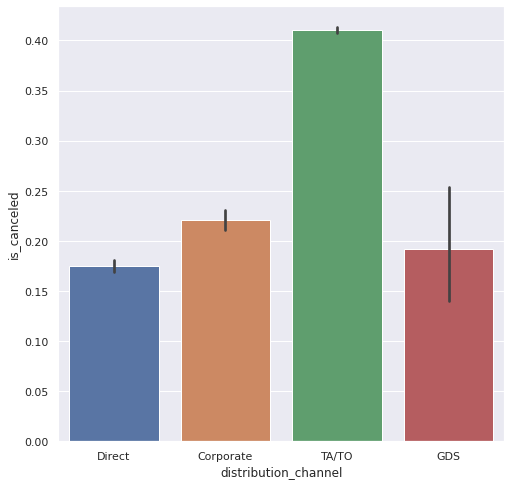

In [30]:
# change Undefined with mode
df.loc[df["distribution_channel"] == 'Undefined', "distribution_channel"] = 'TA/TO'

plt.figure(figsize=(8,8))
sns.barplot(x=df['distribution_channel'], y=df['is_canceled'])
plt.show()

`Distribution Channel` Customer bookings that was advertised or distributed through travel agent/tour operators tend to be canceled, perhaps because there were changes of plan or it is not in accordance with the customers expectation of visit.

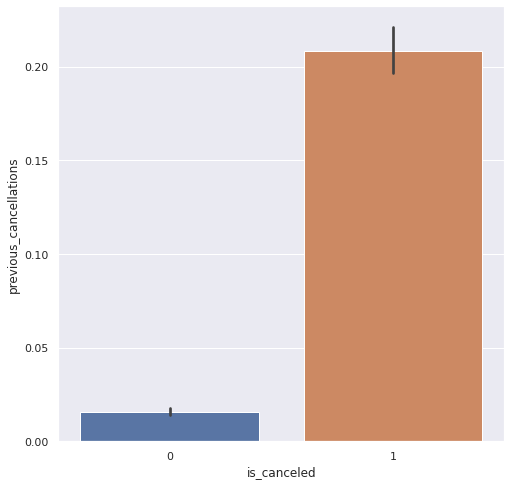

In [31]:
# costumer history of canceling
plt.figure(figsize=(8,8))
sns.barplot(x=df['is_canceled'], y=df['previous_cancellations'])
plt.show()

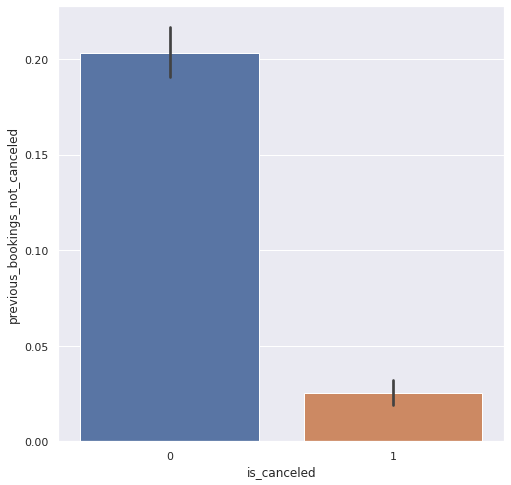

In [32]:
# costumer history of not canceling
plt.figure(figsize=(8,8))
sns.barplot(x=df['is_canceled'], y=df['previous_bookings_not_canceled'])
plt.show()

`Previous cancelations and not canceled` Costumers that already cancel will tend to cancel again. The same tendency for costumers that not cancel their previous bookings, it unlikely they will cancel their booking.

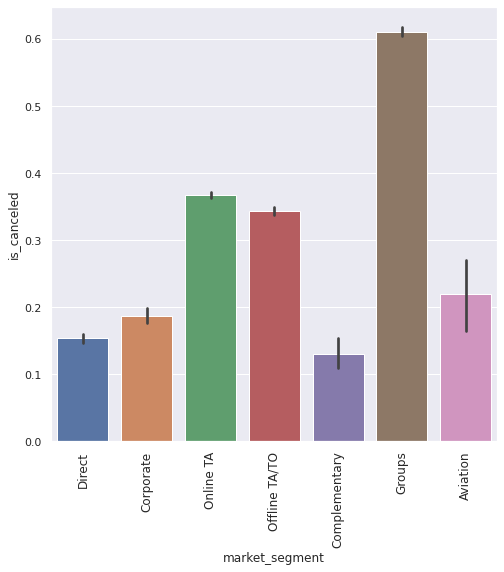

In [33]:
# change Undefined with mode
df.loc[df['market_segment'] == 'Undefined', 'market_segment'] = 'Online TA'

plt.figure(figsize=(8,8))
sns.barplot(x=df['market_segment'], y=df['is_canceled'])
plt.xticks(rotation=90,fontsize=12)
plt.show()

`Market segment` Group market segment tends to cancel. The group here is interpreted as customers that just comes together. They tend to cancel probably because in a group if one or two person cannot go, the whole group cancels the booking.

> #### Guest

In [34]:
#children that are NaN are also considered to be 0 instead
df.loc[df.children.isnull(), 'children'] = 0

#Children are then combined with babies to simplify these features
df['children'] = df['children'].astype(int)
df['children'] = df['children'] + df['babies']
df.drop(columns=['babies'], inplace = True)

In [35]:
pd.crosstab(df['adults'], df['children'], margins=True, margins_name = 'Total')

children,0,1,2,3,9,10,Total
adults,,,,,,,
0,180,4,205,14,0,0,403
1,22577,286,157,6,1,0,23027
2,81560,4658,3369,91,0,2,89680
3,5666,495,41,0,0,0,6202
4,59,3,0,0,0,0,62
5,2,0,0,0,0,0,2
6,1,0,0,0,0,0,1
10,1,0,0,0,0,0,1
20,2,0,0,0,0,0,2


Here we can see the most bookings was made by 2 adults, followed by 1 adult, 3 three adults, 2 adult with 1 child, and 2 adult with 2 child. We can conclude cancelation occured mostly from the bookings that were made by adults only.

> ## Preprocessing

We should now handle the values that are missing, and also unify data that could be in one feature.

- Target: is_canceled
- OneHotEncoder: hotel, meal, distribution_channel, deposit_type, customer_type
- BinaryEncoder: country, market_segment, reserved_room_type
- Standard scaler: adults
- Passthrough: babies, booking_changes, total_of_special_requests

> #### Feature Selection 

Find numeric and categoric attributes that have the best correlation with is_canceled, and eliminate if correlation score below 0.01 

In [36]:
# encode categorical
cat_var = [col for col in df.columns if df[col].dtype == 'O']
cat_var = df[cat_var]
le = LabelEncoder()

for i in cat_var:
    cat_var[i]=le.fit_transform(cat_var[i])
cat_var['is_canceled'] = df['is_canceled']

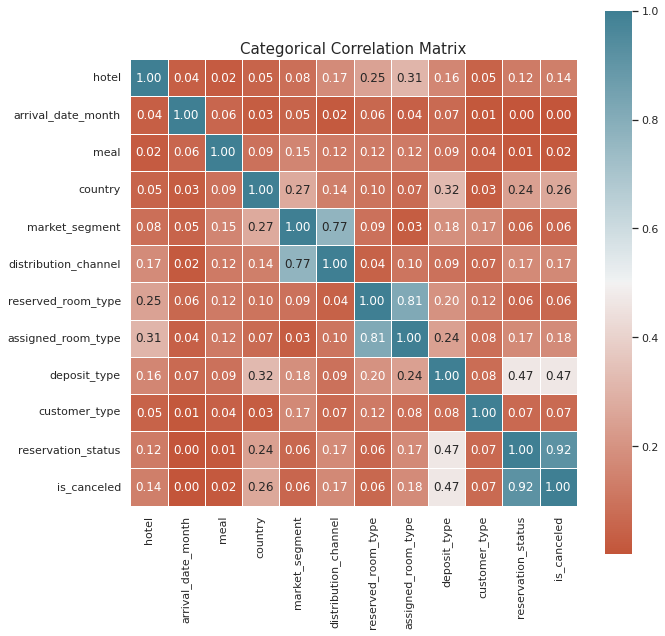

In [37]:
# categorical correlation matrix
plt.figure(figsize=(10,10))
palette=sns.diverging_palette(20, 220, n=256)
corr = cat_var.corr(method='pearson').abs()
sns.heatmap(corr, annot=True, fmt='.2f', cmap=palette, square=True, linewidths=.5)
plt.title('Categorical Correlation Matrix', size=15)
plt.show()

Beside low correlation score, some attributes found not relevant like counrty. And reservation status are the same meaning with is_canceled. so these attribute will drop in preprocessing section.

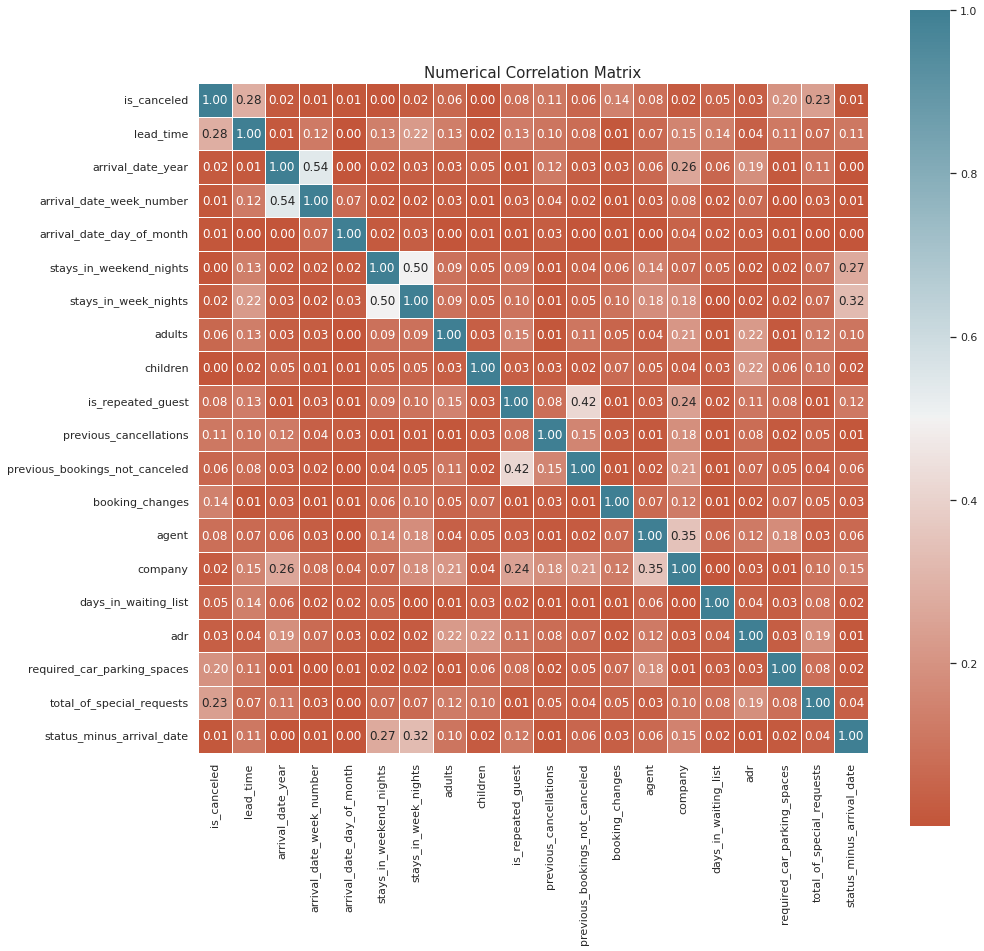

In [38]:
# numerical correlation matrix
plt.figure(figsize=(15,15))
palette=sns.diverging_palette(20, 220, n=256)
corr = df.corr(method='pearson').abs()
sns.heatmap(corr, annot=True, fmt='.2f', cmap=palette, square=True, linewidths=.5)
plt.title('Numerical Correlation Matrix', size=15)
plt.show()

Some attributes with low correlation score and even high will selected based on relevance and will not use for modeling and that attributes will be drop.

In [39]:
# drop irrelevant attributes 
df.drop(['agent','company','country','reservation_status','stays_in_week_nights','stays_in_weekend_nights','arrival_date_day_of_month',
         'arrival_date_week_number','arrival_date_year','reservation_status_date','arrival_date_full','arrival_date_month'], axis=1, inplace=True)

In [40]:
# transformer
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'), ['hotel', 'meal', 'distribution_channel', 'deposit_type', 'customer_type']),
    ('binary', ce.BinaryEncoder(), ['market_segment', 'reserved_room_type', 'assigned_room_type']),
], remainder = 'passthrough')

In [41]:
# define target
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

In [42]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state=1)

In [43]:
testing = pd.DataFrame(transformer.fit_transform(X_train),columns=transformer.get_feature_names())
testing.head()

,onehot__x0_City Hotel,onehot__x0_Resort Hotel,onehot__x1_BB,onehot__x1_FB,onehot__x1_HB,onehot__x1_SC,onehot__x2_Corporate,onehot__x2_Direct,onehot__x2_GDS,onehot__x2_TA/TO,...,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,status_minus_arrival_date
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,156.00,0.0,3.0,3.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,4.0,0.0,102.00,0.0,3.0,3.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,65.00,0.0,0.0,3.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,64.68,0.0,1.0,3.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3.0,0.0,0.0,0.0,73.80,0.0,2.0,1.0


> ## Methodology (Modeling/Analysis)

- Modeling
- Handling Imbalance
- Compare Before/After
- Hyperparameter Tuning
- Feature Importance
- Compare Before/After

In [44]:
# define model
lr = LogisticRegression(random_state = 1)
dt = DecisionTreeClassifier(random_state = 1)
rf = RandomForestClassifier(random_state = 1)
lgbm = lightgbm.LGBMClassifier(random_state = 1)
xgb = XGBClassifier(random_state = 1)

In [45]:
# pipeline model
lr_pipe = Pipeline([('transformer', transformer), ('model', lr)])
dt_pipe = Pipeline([('transformer', transformer), ('model', dt)])
rf_pipe = Pipeline([('transformer', transformer), ('model', rf)])
lgbm_pipe = Pipeline([('transformer', transformer), ('model', lgbm)])
xgb_pipe = Pipeline([('transformer', transformer), ('model', xgb)])

In [46]:
# model cv
def model_eval(model, metric):
    model_cv = cross_val_score(model, X_train, y_train, cv = StratifiedKFold(n_splits = 5), scoring = metric)
    return model_cv

In [47]:
# cross validation
lr_pipe_cv = model_eval(lr_pipe, 'precision')
dt_pipe_cv = model_eval(dt_pipe, 'precision')
rf_pipe_cv = model_eval(rf_pipe, 'precision')
lgbm_pipe_cv = model_eval(lgbm_pipe, 'precision')
xgb_pipe_cv = model_eval(xgb_pipe, 'precision')

In [48]:
# cv, mean, std score
score_cv = [lr_pipe_cv, dt_pipe_cv, rf_pipe_cv, lgbm_pipe_cv, xgb_pipe_cv]
score_mean = [lr_pipe_cv.mean(), dt_pipe_cv.mean(), rf_pipe_cv.mean(), lgbm_pipe_cv.mean(), xgb_pipe_cv.mean()]
score_std = [lr_pipe_cv.std(), dt_pipe_cv.std(), rf_pipe_cv.std(), lgbm_pipe_cv.std(), xgb_pipe_cv.std()]

In [49]:
# fitting model
for model in [lr_pipe, dt_pipe, rf_pipe, lgbm_pipe, xgb_pipe]:
    model.fit(X_train, y_train)

In [50]:
# precision score
score_precision = [precision_score(y_test, lr_pipe.predict(X_test)),
                   precision_score(y_test, dt_pipe.predict(X_test)),
                   precision_score(y_test, rf_pipe.predict(X_test)),
                   precision_score(y_test, lgbm_pipe.predict(X_test)),
                   precision_score(y_test, xgb_pipe.predict(X_test))]

In [51]:
# scoring summary
model_name = ['Logistic Regression', 'Decision Tree Classifier ', 'Random Forest Classifier', 'Light Gradient Boosting Machine', 'Xtreme Gradient Boosting']
model_summary = pd.DataFrame({
    'Algorithm': model_name,
    'Cross Validation': score_cv,
    'Mean': score_mean,
    'Standard Deviation': score_std,
    'Precision Score': score_precision
})

In [52]:
model_summary

,Algorithm,Cross Validation,Mean,Standard Deviation,Precision Score
0,Logistic Regression,"[0.8315330286663897, 0.8263201320132013, 0.813...",0.825412,0.009601,0.838797
1,Decision Tree Classifier,"[0.8218872138470128, 0.8285553681843733, 0.820...",0.823564,0.003334,0.825855
2,Random Forest Classifier,"[0.8931159420289855, 0.8945128438972488, 0.901...",0.895132,0.003772,0.898631
3,Light Gradient Boosting Machine,"[0.8941176470588236, 0.8877388535031847, 0.892...",0.890451,0.003396,0.893400
4,Xtreme Gradient Boosting,"[0.896551724137931, 0.8902762603402529, 0.8962...",0.893393,0.003385,0.896767


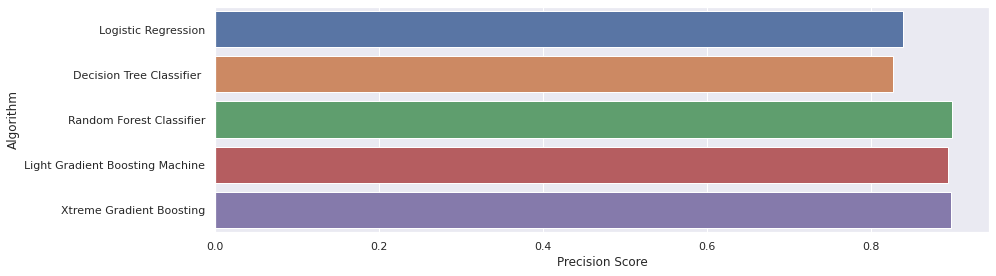

In [53]:
# plotting precision score
plt.figure(figsize=(14,4))
sns.barplot(data=model_summary, y='Algorithm', x='Precision Score')
plt.tight_layout()

From the baseline model we can see that Random Forest Model has the highest precision compared to the other models having 89.8% score. And the most stable model seeing from the standard deviation and mean score would be the Random Forest. Based on that, Random Forest would be the best to be used for cancelation prediction.

> #### Handling Imbalance

> ##### Random Under Sampling

In [54]:
# define rus
rus = RandomUnderSampler(random_state = 1)
X_under, y_under = rus.fit_resample(X_train, y_train)

In [55]:
# pipeline model with rus
lr_rus_pipe = Pipeline([('transformer', transformer), ('rus', rus), ('model', lr)])
dt_rus_pipe = Pipeline([('transformer', transformer), ('rus', rus), ('model', dt)])
rf_rus_pipe = Pipeline([('transformer', transformer), ('rus', rus), ('model', rf)])
lgbm_rus_pipe = Pipeline([('transformer', transformer), ('rus', rus), ('model', lgbm)])
xgb_rus_pipe = Pipeline([('transformer', transformer), ('rus', rus), ('model', xgb)])

In [56]:
# rus model cv
def model_eval(model, metric):
    model_cv = cross_val_score(model, X_under, y_under, cv = StratifiedKFold(n_splits = 5), scoring = metric)
    return model_cv

In [57]:
# rus cross validation
lr_rus_pipe_cv = model_eval(lr_rus_pipe, 'precision')
dt_rus_pipe_cv = model_eval(dt_rus_pipe, 'precision')
rf_rus_pipe_cv = model_eval(rf_rus_pipe, 'precision')
lgbm_rus_pipe_cv = model_eval(lgbm_rus_pipe, 'precision')
xgb_rus_pipe_cv = model_eval(xgb_rus_pipe, 'precision')

In [58]:
# rus cv, mean, std score
score_cv = [lr_rus_pipe_cv, dt_rus_pipe_cv, rf_rus_pipe_cv, lgbm_rus_pipe_cv, xgb_rus_pipe_cv]
score_mean = [lr_rus_pipe_cv.mean(), dt_rus_pipe_cv.mean(), rf_rus_pipe_cv.mean(), lgbm_rus_pipe_cv.mean(), xgb_rus_pipe_cv.mean()]
score_std = [lr_rus_pipe_cv.std(), dt_pipe_cv.std(), rf_rus_pipe_cv.std(), lgbm_pipe_cv.std(), xgb_pipe_cv.std()]

In [59]:
# fitting rus model
for model in [lr_rus_pipe, dt_rus_pipe, rf_rus_pipe, lgbm_rus_pipe, xgb_rus_pipe]:
    model.fit(X_under, y_under)

In [60]:
# precision score
score_precision = [precision_score(y_test, lr_rus_pipe.predict(X_test)),
                   precision_score(y_test, dt_rus_pipe.predict(X_test)),
                   precision_score(y_test, rf_rus_pipe.predict(X_test)),
                   precision_score(y_test, lgbm_rus_pipe.predict(X_test)),
                   precision_score(y_test, xgb_rus_pipe.predict(X_test))]

In [61]:
# scoring rus summary
model_name_rus = ['Logistic Regression', 'Decision Tree Classifier ', 'Random Forest Classifier', 'Light Gradient Boosting Machine', 'Xtreme Gradient Boosting']
rus_summary = pd.DataFrame({
    'Algorithm with RUS': model_name_rus,
    'Cross Validation': score_cv,
    'Mean': score_mean,
    'Standard Deviation': score_std,
    'Precision Score': score_precision
})

In [62]:
rus_summary

,Algorithm with RUS,Cross Validation,Mean,Standard Deviation,Precision Score
0,Logistic Regression,"[0.7953125, 0.7876301672451878, 0.784562926224...",0.790749,0.004047,0.683850
1,Decision Tree Classifier,"[0.8564613441840887, 0.8519759810082391, 0.849...",0.853493,0.003334,0.784678
2,Random Forest Classifier,"[0.9077306733167082, 0.8979562255399334, 0.900...",0.902095,0.003384,0.847828
3,Light Gradient Boosting Machine,"[0.8968964488212474, 0.8915339979169766, 0.883...",0.891193,0.003396,0.829038
4,Xtreme Gradient Boosting,"[0.8992826818913775, 0.890625, 0.8868087557603...",0.893345,0.003385,0.831943


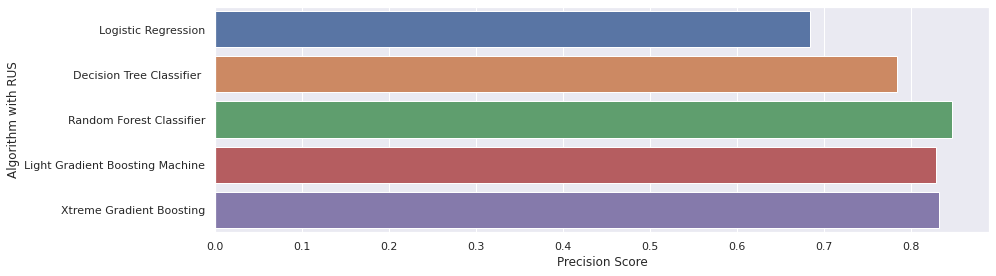

In [63]:
# plotting precision score with rus
plt.figure(figsize=(14,4))
sns.barplot(data=rus_summary, y='Algorithm with RUS', x='Precision Score')
plt.tight_layout()

Undersampling unfortunately gives a bad effect for the precision score with all of the models metric decreasing. Random Forest can be seen still has the second highest score 75% and the most stable.

> ##### Random Over Sampling

In [64]:
# define ros
ros = RandomOverSampler(random_state = 1)
X_over, y_over = ros.fit_resample(X_train, y_train)

In [65]:
# pipeline model with ros
lr_ros_pipe = Pipeline([('transformer', transformer), ('ros', ros), ('model', lr)])
dt_ros_pipe = Pipeline([('transformer', transformer), ('ros', ros), ('model', dt)])
rf_ros_pipe = Pipeline([('transformer', transformer), ('ros', ros), ('model', rf)])
lgbm_ros_pipe = Pipeline([('transformer', transformer), ('ros', ros), ('model', lgbm)])
xgb_ros_pipe = Pipeline([('transformer', transformer), ('ros', ros), ('model', xgb)])

In [66]:
# ros model cv
def model_eval(model, metric):
    model_cv= cross_val_score(model, X_over, y_over, cv = StratifiedKFold(n_splits = 5), scoring = metric)
    return model_cv

In [67]:
# ros cross validation
lr_ros_pipe_cv = model_eval(lr_ros_pipe, 'precision')
dt_ros_pipe_cv = model_eval(dt_ros_pipe, 'precision')
rf_ros_pipe_cv = model_eval(rf_ros_pipe, 'precision')
lgbm_ros_pipe_cv = model_eval(lgbm_ros_pipe, 'precision')
xgb_ros_pipe_cv = model_eval(xgb_ros_pipe, 'precision')

In [68]:
# ros cv, mean, std score
score_cv = [lr_ros_pipe_cv, dt_ros_pipe_cv, rf_ros_pipe_cv, lgbm_ros_pipe_cv, xgb_ros_pipe_cv]
score_mean = [lr_ros_pipe_cv.mean(), dt_ros_pipe_cv.mean(), rf_ros_pipe_cv.mean(), lgbm_ros_pipe_cv.mean(), xgb_ros_pipe_cv.mean()]
score_std = [lr_ros_pipe_cv.std(), dt_pipe_cv.std(), rf_ros_pipe_cv.std(), lgbm_pipe_cv.std(), xgb_pipe_cv.std()]

In [69]:
# fitting ros model
for model in [lr_ros_pipe, dt_ros_pipe, rf_ros_pipe, lgbm_ros_pipe, xgb_ros_pipe]:
    model.fit(X_over, y_over)

In [70]:
# ros precision score
score_precision = [precision_score(y_test, lr_ros_pipe.predict(X_test)),
                   precision_score(y_test, dt_ros_pipe.predict(X_test)),
                   precision_score(y_test, rf_ros_pipe.predict(X_test)),
                   precision_score(y_test, lgbm_ros_pipe.predict(X_test)),
                   precision_score(y_test, xgb_ros_pipe.predict(X_test))]

In [71]:
# scoring ros summary
model_name_ros = ['Logistic Regression', 'Decision Tree Classifier ', 'Random Forest Classifier', 'Light Gradient Boosting Machine', 'Xtreme Gradient Boosting']
ros_summary = pd.DataFrame({
    'Algorithm with ROS': model_name_ros,
    'Cross Validation': score_cv,
    'Mean': score_mean,
    'Standard Deviation': score_std,
    'Precision Score': score_precision
})

In [72]:
ros_summary 

,Algorithm with ROS,Cross Validation,Mean,Standard Deviation,Precision Score
0,Logistic Regression,"[0.7977454816471027, 0.7892695539754363, 0.793...",0.793543,0.002982,0.683490
1,Decision Tree Classifier,"[0.8912001300073129, 0.897423352902805, 0.8952...",0.893629,0.003334,0.826485
2,Random Forest Classifier,"[0.9256880733944954, 0.9303961805846386, 0.932...",0.929119,0.002500,0.883394
3,Light Gradient Boosting Machine,"[0.8927543813758828, 0.8936188811188811, 0.894...",0.893966,0.003396,0.835148
4,Xtreme Gradient Boosting,"[0.9010139199175116, 0.8989216021910305, 0.902...",0.900385,0.003385,0.843736


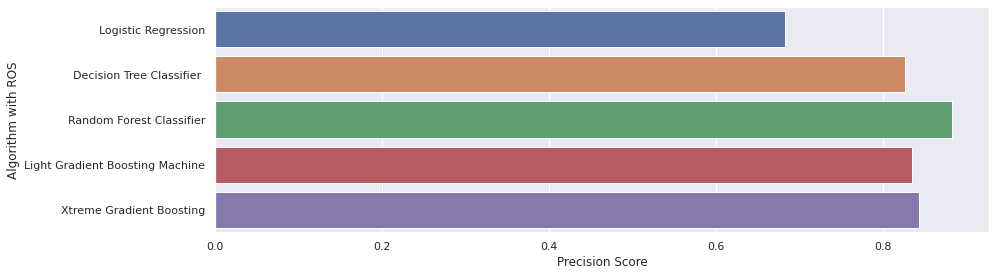

In [73]:
# plotting precision score with ros
plt.figure(figsize=(14,4))
sns.barplot(data=ros_summary, y='Algorithm with ROS', x='Precision Score')
plt.tight_layout()

We tried oversampling and compared the results with base model and undersampling. We can see oversampling is still lower than base model but higher for a couple models compared to undersampling handling. The Random Forest strive at oversampling with the highest precision score 88% and the most stable even more stable than any model in the baseline.
Random Forest with random over sampling will be tuning for the next process

> Hyperparameter tuning

In [74]:
# define pipeline with ros
estimator = Pipeline([
    ('transformer', transformer),
    ('ros', ros),
    ('model', rf)])
# define parameters
hyperparam_space = {
    'model__n_estimators': [100, 120, 150],
    'model__criterion': ['entropy', 'gini'], 
    'model__max_depth': [1,3,5,7,9],
		'model__min_samples_leaf': [1,3,5]
}

In [75]:
# define tuning
random = RandomizedSearchCV(
    estimator,
    param_distributions = hyperparam_space,
    cv = StratifiedKFold(n_splits = 5),
    scoring = 'precision',
    n_iter = 10,
    verbose = 2,
    random_state = 1,
    n_jobs = -1
)

random.fit(X_train, y_train)

print('best score', random.best_score_)
print('best param', random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3, model__n_estimators=120; total time=  21.7s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3, model__n_estimators=120; total time=  24.4s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3, model__n_estimators=120; total time=  24.7s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3, model__n_estimators=120; total time=  25.6s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3, model__n_estimators=120; total time=  20.3s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=5, model__n_estimators=100; total time=  27.1s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=5, model__n_estimators=100; total time=  28.1s
[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=5,

The best parameters :
- n_estimators : 120
- min_samples_leaf : 5
- max_depth : 1
- criterion : gini

Grid Search has been tested and takes too long to run and provides no significant additional value. Randomize Search is the best option in this case.

In [76]:
# comparing before/after score
estimator.fit(X_train, y_train)
y_pred_estimator = estimator.predict(X_test)
before = precision_score(y_test, y_pred_estimator)

random.best_estimator_.fit(X_train, y_train)
y_predict = random.best_estimator_.predict(X_test)
after = precision_score(y_test, y_predict)

score_list = [before, after]
model_tuning = ['Before Tuning', 'After Tuning']
best_summary = pd.DataFrame({
    'Random Forest Classifier': model_tuning,
    'Precision Score': score_list
})

In [77]:
best_summary

,Random Forest Classifier,Precision Score
0,Before Tuning,0.883394
1,After Tuning,0.912669


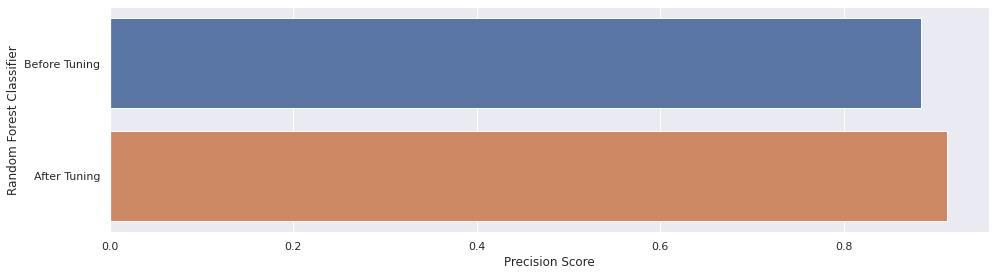

In [78]:
# plotting best precision score before and after tuning
plt.figure(figsize=(14,4))
sns.barplot(data=best_summary, y='Random Forest Classifier', x='Precision Score')
plt.tight_layout()

After tuning, score significant increasing . Therefore, tuned model will be used for prediction

In [79]:
result_cv = pd.DataFrame(random.cv_results_)
result_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_leaf,param_model__max_depth,param_model__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,22.458243,1.989336,0.863921,0.324361,120,3,3,gini,"{'model__n_estimators': 120, 'model__min_sampl...",0.835955,0.830097,0.841514,0.820824,0.834400,0.832558,0.006912,4
1,27.430232,0.597956,0.670681,0.227689,100,5,7,gini,"{'model__n_estimators': 100, 'model__min_sampl...",0.830981,0.818696,0.823199,0.820653,0.833846,0.825475,0.005912,8
2,41.734197,6.690706,1.285364,0.700679,120,5,9,entropy,"{'model__n_estimators': 120, 'model__min_sampl...",0.826953,0.821998,0.824471,0.820875,0.829196,0.824699,0.003075,9
3,26.336219,3.591350,1.046576,0.643699,120,1,3,gini,"{'model__n_estimators': 120, 'model__min_sampl...",0.836233,0.830097,0.842209,0.827459,0.835048,0.834209,0.005124,3
4,28.854792,1.470004,0.854486,0.154557,100,5,9,gini,"{'model__n_estimators': 100, 'model__min_sampl...",0.827852,0.821335,0.828261,0.824818,0.827894,0.826032,0.002656,7


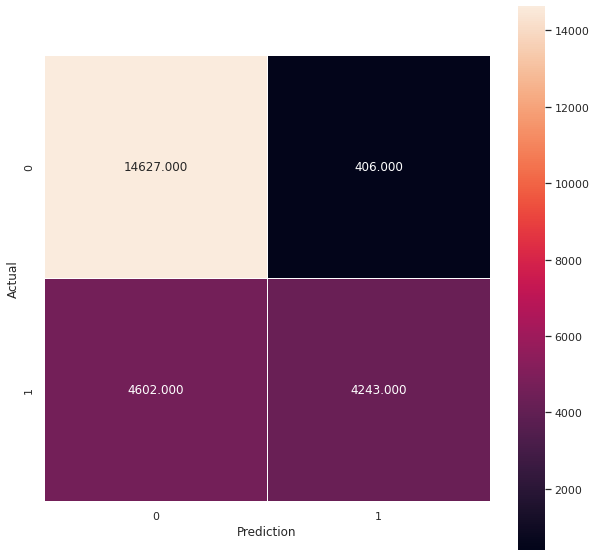

In [80]:
# define confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square=True)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [81]:
best_model = random.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hotel', 'meal',
                                                   'distribution_channel',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['market_segment',
                                                   'reserved_room_type',
                                                   'assigned_room_type'])])),
                ('ros', RandomOverSampler(random_state=1)),
                ('model',
                 RandomForestClassifier(max_depth=1, min_samples_leaf=5,
                                        n_estimators=120, random_state=1))])

> #### Feature Importance

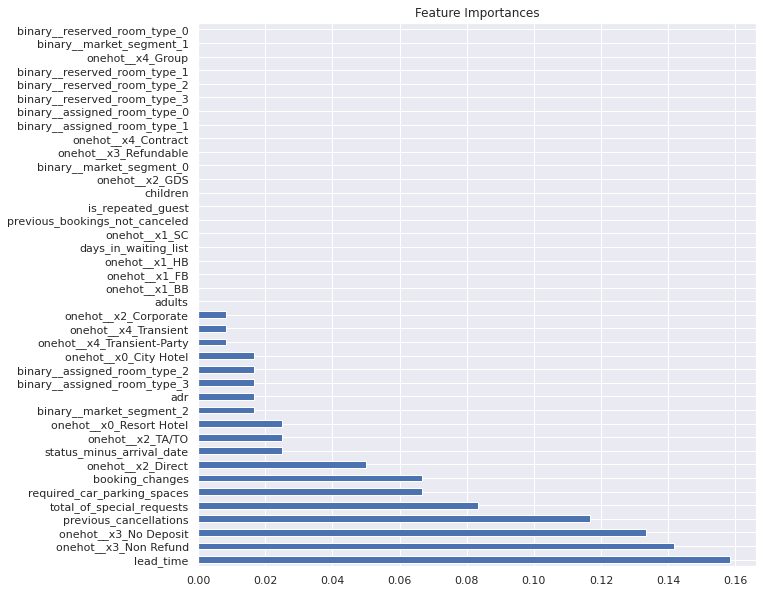

In [82]:
# feature importance
plt.figure(figsize=(10,10))
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names()).sort_values(ascending = False)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

In [83]:
# classification report
y_pred = random.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85     15033
           1       0.91      0.48      0.63      8845

    accuracy                           0.79     23878
   macro avg       0.84      0.73      0.74     23878
weighted avg       0.82      0.79      0.77     23878



> ## Conclusion and Recommendation

#### Recommendation

From exploratory data analysis and feature importance in prediciton model we can recommend hotels the following to mitigate cancelations:

- City hotels can try to keep up with competitors with promoting saving packages especially in high seasons. If the price cannot be cut significantly for the promo then giving addiitional services like free one day spa or customer with FB meal booking gets free tickets to local attraction. These would be a great option to consider. Other than that assigning a sharing room (bunk beds) as an alternative option especially for transient costumers can be much more cheaper for them and would likely retain their booking.

- Early detection system has to be properly managed especially in high season to avoid people getting into waiting list and cancelation prior to arrival. Hotel regulations should also be simplified to avoid customer confusion in particular hotels can give a terms for high price booking considered as non refundables which migth reduce cancelations for both case.

- Mitigating the high chance of a costumer changing plans perhaps can be dealt with offering a form with multiple itinerary choice they can easily pick, alongside with special requests that a customer can have with no extra charge. Giving awareness to customer of such service is a good complimentary. Coupling promo with services will really improve customer comofort.

- Promotion should be direct to give a more personal approach to customers to increase their convinience. This can be coupled with probably a points system that also increases customer loyalty and makes them a regular guest at the hotel especially for the transient type costumers and groups.

#### Conclusion

From here we can conclude that if we try to approach with prediction model and hotels could filter costumers that might cancel early on, then our model could make hotels avoid a loss of 91% costumers due to the various reasons of cancelations early on. 

From the price perspective, assuming that from the data which is 100 USD hotel rates which are the ones that are mostly being canceled. Imagine then that from 100 costumers if we use the model we can avoid loss of 9100 USD.

Despite the precision score is already good, additional data that hotel management can try to acquire would always be good to enrich the model and upgrade it periodically to get a much more precise prediction.

`Thank You`